In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
matplotlib.style.use('seaborn')
matplotlib.rcParams['figure.figsize'] = (18,6)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

C:\Users\wb8by\AppData\Local\Temp/ipykernel_21956/3666127296.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  matplotlib.style.use('seaborn')


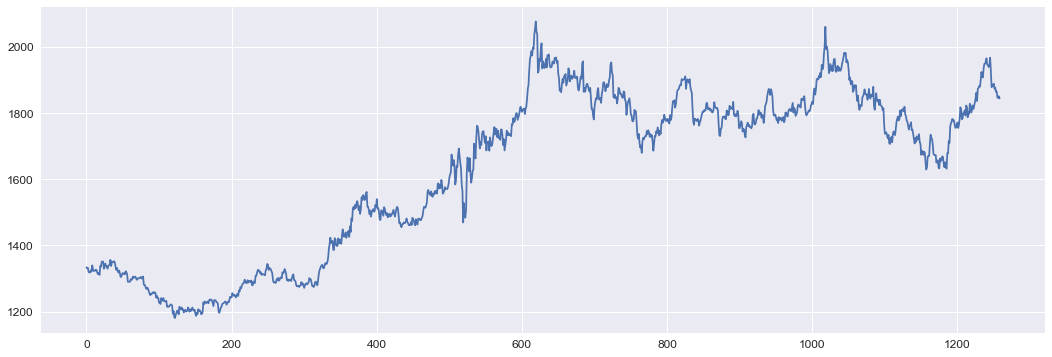

In [26]:
df = pd.read_csv('HistoricalData_Gold.csv')
price = np.flip(df['Open'].to_numpy())
plt.plot(price)

# Create Data

In [71]:
z = np.zeros((1000,100))
for i in range(1000):
  z[i,:] = price[i:(i+100)]

z_test = np.zeros((150,100))
for i in range(150):
  z_test[i,:] = price[(i+1000):(i+1100)]

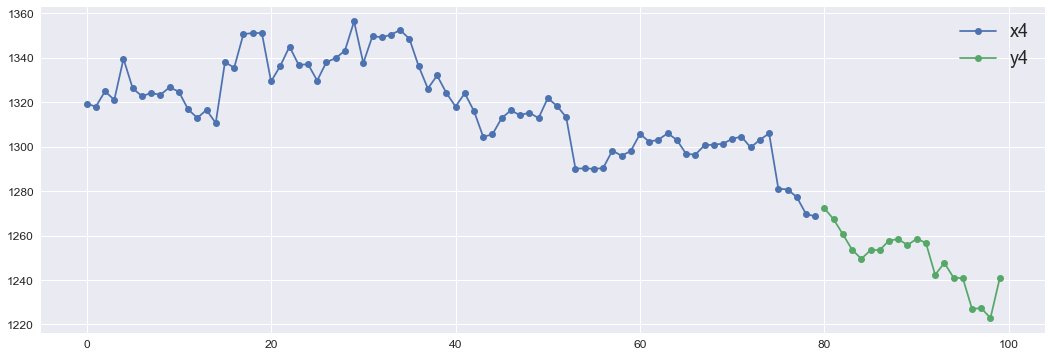

In [104]:
for idx in np.random.randint(0, high=100, size=1):
  plt.plot(np.arange(0,80),z[idx,0:80], marker='o', label = 'x'+str(idx));
  plt.plot(np.arange(80,100),z[idx,80:100], marker='o', label='y'+str(idx));
  plt.legend(fontsize = 18);

In [54]:
z.shape

(1000, 100)

Plot some data

In [164]:
# Demean the data
z_demean = np.zeros((1000,100))
m = np.mean(z, 0)
for c in range(100):
  z_demean[:,c] = z[:,c] - m[c]

In [165]:
# Compute the covariance
C = np.zeros((100,100))
for r in range(0,1000):
  C = C + np.matmul(z_demean[r:(r+1),:].T, z_demean[r:(r+1),:]) 
C = C/1000
print(np.shape(C))

(100, 100)


C:\Users\wb8by\AppData\Local\Temp/ipykernel_21956/2998647476.py:2: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


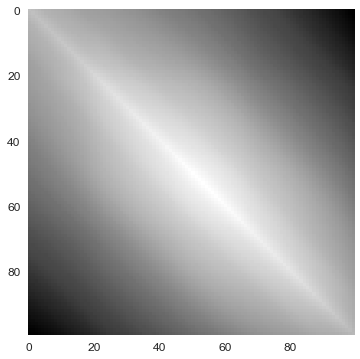

In [167]:
plt.imshow(C, cmap='gray')
plt.grid(b=None)

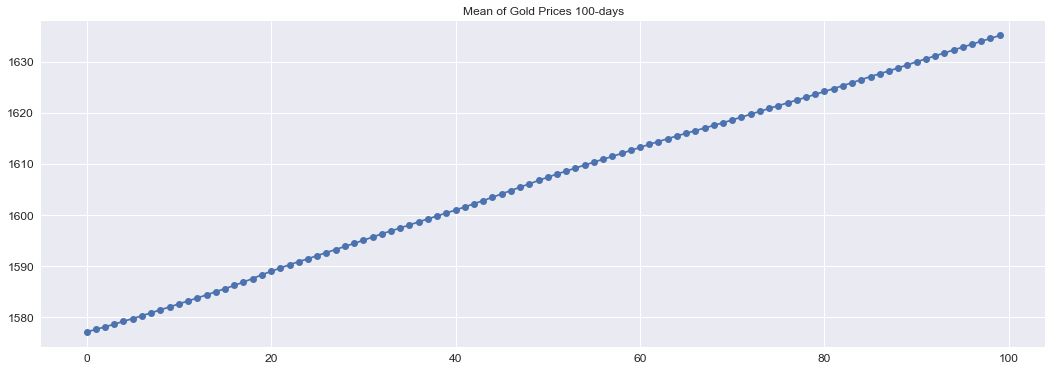

In [105]:
plt.plot(m, marker='o')
plt.title('Mean of Gold Prices 100-days');

In [89]:
m_a = m[0:80]
m_b = m[80:100]
Caa = C[0:80,0:80]
Cab = C[0:80,80:100]
Cba = C[80:100,0:80]
Cbb = C[80:100,80:100]
print('Shape ma: '+str(np.shape(m_a)))
print('Shape mb: '+str(np.shape(m_b)))
print('Shape Caa: '+str(np.shape(Caa)))
print('Shape Cab: '+str(np.shape(Cab)))
print('Shape Cba: '+str(np.shape(Cba)))
print('Shape Cbb: '+str(np.shape(Cbb)))
CaaInv = np.linalg.inv(Caa)

Shape ma: (80,)
Shape mb: (20,)
Shape Caa: (80, 80)
Shape Cab: (80, 20)
Shape Cba: (20, 80)
Shape Cbb: (20, 20)


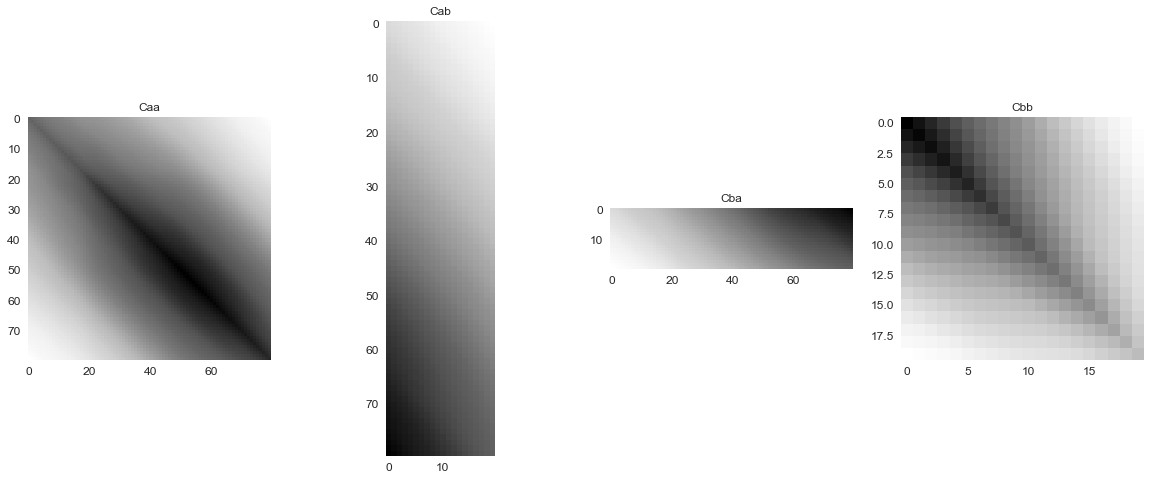

In [168]:
plt.figure(figsize=(20,8))
plt.subplot(141)
plt.imshow(Caa)
plt.grid(None)
plt.title('Caa')
plt.subplot(142)
plt.imshow(Cab)
plt.grid(None) 
plt.title('Cab')
plt.subplot(143)
plt.imshow(Cba)
plt.grid(None) 
plt.title('Cba')
plt.subplot(144)
plt.imshow(Cbb)
plt.grid(None) 
plt.title('Cbb')
plt.savefig('covariance.png', dpi=500, bbox_inches='tight', pad_inches=0.1);
plt.show()

In [90]:
np.matmul(Cba,CaaInv)

array([[ 0.03749953, -0.07085966, -0.00447965, ...,  0.02316463,
         0.03112483,  0.94492646],
       [ 0.01727988, -0.01184042, -0.07205597, ..., -0.0105195 ,
         0.0533082 ,  0.92135273],
       [ 0.00745539, -0.02196696, -0.0134208 , ..., -0.08916215,
         0.01860332,  0.92157315],
       ...,
       [ 0.09363336, -0.05772116, -0.03922949, ..., -0.0606821 ,
        -0.00958737,  0.77293192],
       [ 0.0869108 , -0.0149793 , -0.05982676, ...,  0.09744182,
        -0.03554085,  0.72021112],
       [ 0.13911132, -0.06930188, -0.01766434, ...,  0.03709396,
         0.1214111 ,  0.64563212]])

In [86]:
def pred(xa,m_a,m_b,Cba,CaaInv):
  return m_b + np.matmul(np.matmul(Cba,CaaInv),xa-m_a)

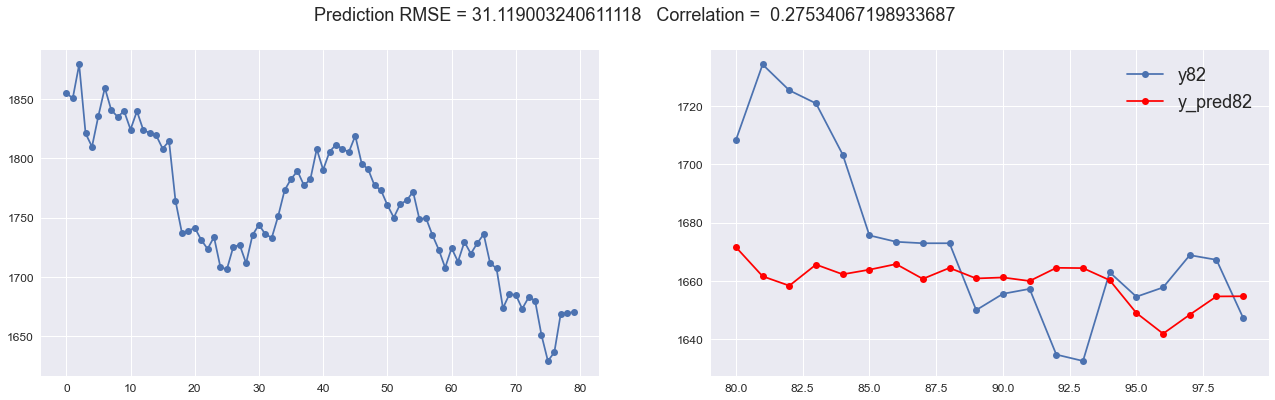

In [173]:
for idx in np.random.randint(0, high=100, size=1):
  Y_pred = pred(z_test[idx,0:80],m_a,m_b,Cba,CaaInv)
  plt.figure(figsize=(22,6))
  plt.subplot(121)
  plt.plot(np.arange(0,80),z_test[idx,0:80], marker='o', label = 'x'+str(idx));
  plt.subplot(122)
  plt.plot(np.arange(80,100),z_test[idx,80:100], marker='o', label='y'+str(idx));
  plt.plot(np.arange(80,100),Y_pred, marker='o', color='r', label='y_pred'+str(idx));
  plt.suptitle('Prediction RMSE = '+str(np.sqrt(np.square(z_test[idx,80:100]-Y_pred).mean()))+
                '   Correlation =  '+str(np.corrcoef(z_test[idx,80:100],Y_pred)[0,1]), fontsize = 18);
  plt.legend(fontsize = 18);

In [155]:
CC = Cbb - np.matmul(np.matmul(Cba, np.linalg.pinv(Caa)), Cab)
eVals, eVecs = np.linalg.eig(CC)

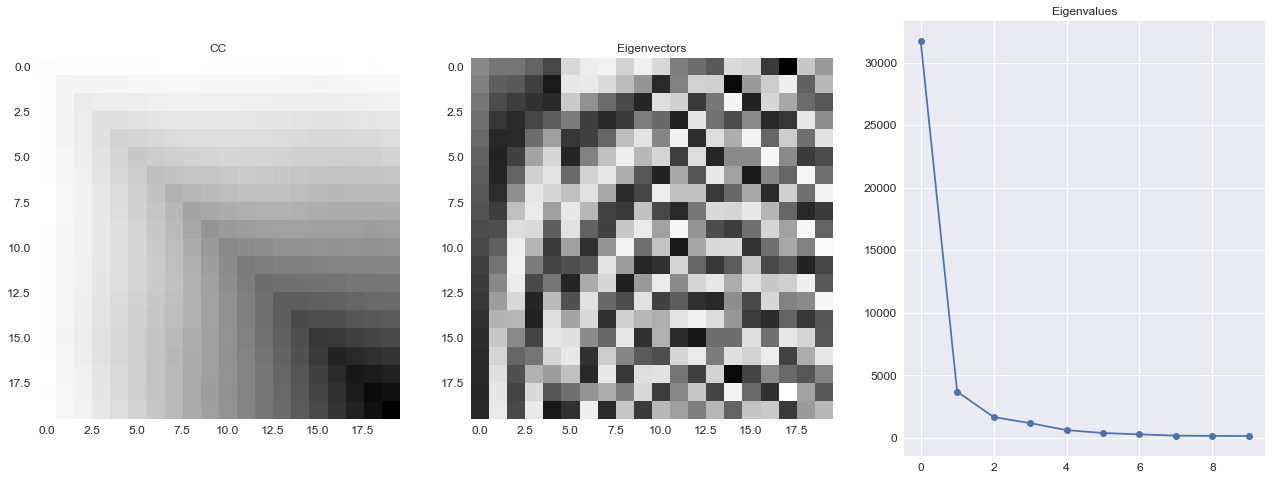

In [156]:
plt.figure(figsize=(22,8))
plt.subplot(131)
plt.imshow(CC)
plt.grid(None)
plt.title('CC')
plt.subplot(132)
plt.imshow(eVecs.real)
plt.grid(None)
plt.title('Eigenvectors')
plt.subplot(133)
plt.plot(eVals[0:10].real, 'o-')
plt.title('Eigenvalues');
plt.savefig('ConditionaCovariance.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

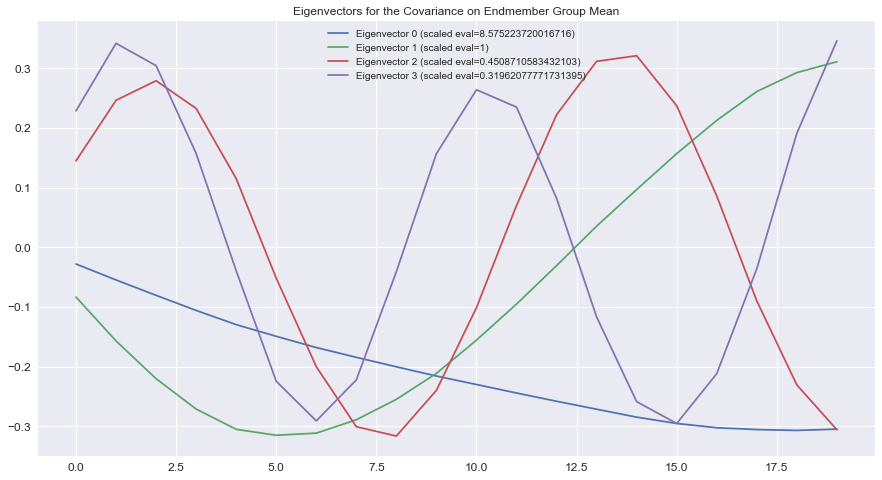

In [157]:
plt.figure(figsize=(15,8))
plt.plot(np.arange(0,20),(-1)*eVecs[:,0].real.flatten(), label='Eigenvector 0 (scaled eval='+str(eVals[0].real/eVals[1].real)+')')
plt.plot(np.arange(0,20),(-1)*eVecs[:,1].real.flatten(), label='Eigenvector 1 (scaled eval='+str(1)+')')
plt.plot(np.arange(0,20),eVecs[:,3].real.flatten(), label='Eigenvector 2 (scaled eval='+str(eVals[2].real/eVals[1].real)+')')
plt.plot(np.arange(0,20),eVecs[:,4].real.flatten(), label='Eigenvector 3 (scaled eval='+str(eVals[3].real/eVals[1].real)+')')
plt.legend()
plt.title("Eigenvectors for the Covariance on Endmember Group Mean")
plt.savefig('covarianceEigenVectors.png', dpi=500, bbox_inches='tight', pad_inches=0.1);

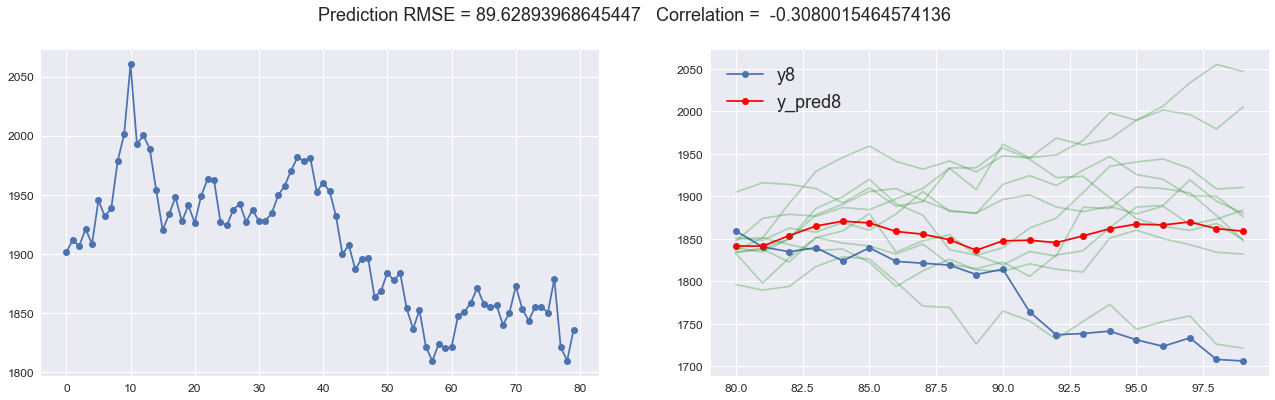

In [197]:
for idx in np.random.randint(0, high=100, size=1):
  Y_pred = pred(z_test[idx,0:80],m_a,m_b,Cba,CaaInv)
  plt.figure(figsize=(22,6))
  plt.subplot(121)
  plt.plot(np.arange(0,80),z_test[idx,0:80], marker='o', label = 'x'+str(idx));
  plt.subplot(122)
  plt.plot(np.arange(80,100),z_test[idx,80:100], marker='o', label='y'+str(idx));
  plt.plot(np.arange(80,100),Y_pred, marker='o', color='r', label='y_pred'+str(idx));
  Y_preds = np.random.multivariate_normal(Y_pred, CC, size=10)
  for Ysample in Y_preds:
    plt.plot(np.arange(80,100),Ysample, color='g', alpha=0.25);
  plt.suptitle('Prediction RMSE = '+str(np.sqrt(np.square(z_test[idx,80:100]-Y_pred).mean()))+
                '   Correlation =  '+str(np.corrcoef(z_test[idx,80:100],Y_pred)[0,1]), fontsize = 18);
  plt.legend(fontsize = 18);

In [198]:
# check how this works based on correlation and rmse on average
n=30000
corr = 0
rmse = 0
for idx in np.random.randint(0, high=100, size=n):
  Y_pred = pred(z_test[idx,0:80],m_a,m_b,Cba,CaaInv)
  corr = corr + np.corrcoef(z_test[idx,80:100],Y_pred)[0,1]
  rmse = rmse + np.sqrt(np.square(z_test[idx,80:100]-Y_pred).mean())
print(corr/n)
print(rmse/n)

0.07195913919447887
54.43294984173742
